In [1]:
# Importation

import pandas as pd
import keras
from keras import layers, models, callbacks
import joblib

import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import numpy as np
import tensorflow as tf

2026-02-10 11:57:17.818541: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-10 11:57:17.819274: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-10 11:57:18.156206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-10 11:57:19.623779: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
df = pd.read_csv("../datas/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
df.tail()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
df.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Machine failure                2
TWF                            2
HDF                            2
PWF                            2
OSF                            2
RNF                            2
dtype: int64

In [7]:
df.Type.value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [8]:
df["Machine failure"].value_counts(normalize=True)

Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64

On a peu de données anormales super.

In [9]:
def preprocess_data(df):
    df = df.set_index(keys="UDI", drop=True)
    df = df.drop(columns=["Product ID"])
    df = df.drop(columns=["TWF", "HDF", "PWF", "OSF", "RNF"]).copy()
    df = pd.get_dummies(
        df, columns=["Type"], prefix="Type", drop_first=True, dtype=int
    )
    return df

df_preprocessed = preprocess_data(df)
df_preprocessed.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M
UDI,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1
2,298.2,308.7,1408,46.3,3,0,1,0
3,298.1,308.5,1498,49.4,5,0,1,0
4,298.2,308.6,1433,39.5,7,0,1,0
5,298.2,308.7,1408,40.0,9,0,1,0


In [10]:
def build_features(df):
    df = df.copy()
    df["Power_kw"] = (df["Torque [Nm]"] * df["Rotational speed [rpm]"]) / 9550
    df["Temp_diff"] = df["Process temperature [K]"] - df["Air temperature [K]"]
    df["Speed_torque_ratio"] = df["Rotational speed [rpm]"] / (df["Torque [Nm]"] + 1)
    max_wear = df["Tool wear [min]"].max()
    df["Wear_level"] = pd.cut(
        df["Tool wear [min]"],
        bins=[0, 80, 160, max_wear + 1],
        labels=[0, 1, 2],
        include_lowest=True,
    )
    df["Wear_level"] = (
        pd.to_numeric(df["Wear_level"], errors="coerce").fillna(0).astype(int)
    )
    df["High_wear"] = (df["Tool wear [min]"] > 200).astype(int)
    df["Thermal_load"] = df["Temp_diff"] * df["Power_kw"]
    df["Mechanical_stress"] = df["Torque [Nm]"] * (1 + df["Tool wear [min]"] / 250)

    return df

df_featured = build_features(df_preprocessed)
df_featured.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M,Power_kw,Temp_diff,Speed_torque_ratio,Wear_level,High_wear,Thermal_load,Mechanical_stress
UDI,,,,,,,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1,6.951079,10.5,35.410959,0,0,72.986325,42.8000
2,298.2,308.7,1408,46.3,3,0,1,0,6.826220,10.5,29.767442,0,0,71.675309,46.8556
3,298.1,308.5,1498,49.4,5,0,1,0,7.748817,10.4,29.722222,0,0,80.587694,50.3880
4,298.2,308.6,1433,39.5,7,0,1,0,5.927068,10.4,35.382716,0,0,61.641508,40.6060
5,298.2,308.7,1408,40.0,9,0,1,0,5.897382,10.5,34.341463,0,0,61.922513,41.4400


In [11]:
df_featured.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'Type_L', 'Type_M', 'Power_kw', 'Temp_diff',
       'Speed_torque_ratio', 'Wear_level', 'High_wear', 'Thermal_load',
       'Mechanical_stress'],
      dtype='object')

<Figure size 1000x1000 with 0 Axes>

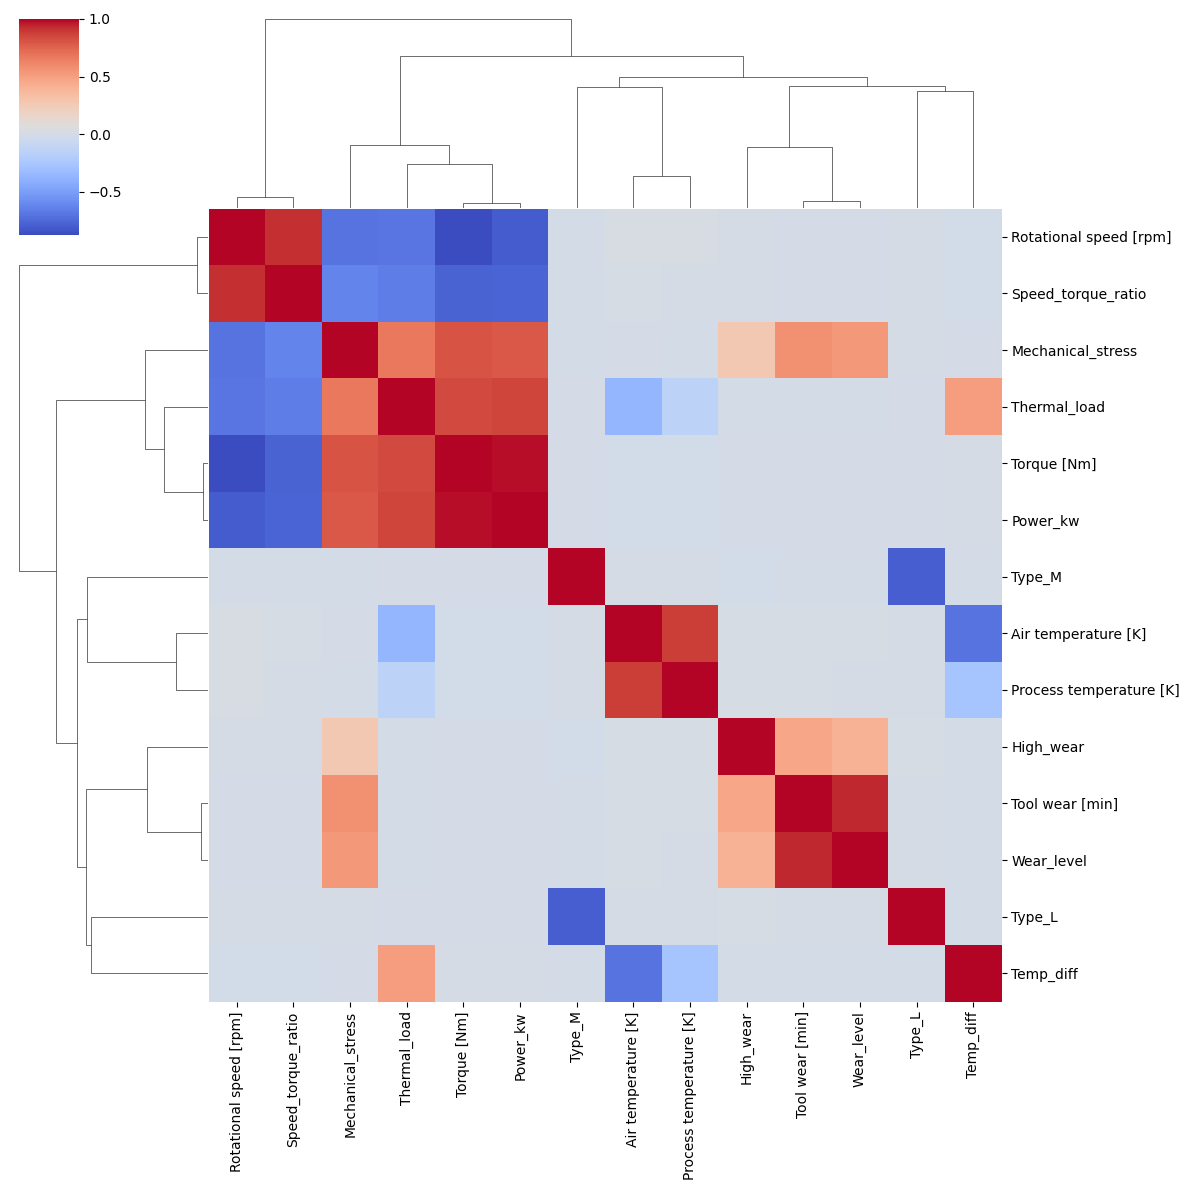

In [12]:
corr = df_featured.drop(columns=["Machine failure"]).corr(method="pearson")

plt.figure(figsize=(10, 10))
sns.clustermap(corr, cmap="coolwarm", figsize=(12, 12), annot=False)
plt.show()

In [13]:
CORRELATION_THRESHOLD = 0.9
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(key=lambda x: x.abs(), ascending=False)
    .reset_index()
)

corr_pairs.columns = ["var1", "var2", "correlation"]
strong_corr_pairs = corr_pairs[corr_pairs["correlation"] > CORRELATION_THRESHOLD]
strong_corr_pairs.head()

,var1,var2,correlation
0,Torque [Nm],Power_kw,0.978828
1,Tool wear [min],Wear_level,0.936736
2,Rotational speed [rpm],Speed_torque_ratio,0.915514


In [14]:
features_to_drop = []
for _, row in strong_corr_pairs.iterrows():
    var1, var2 = row["var1"], row["var2"]
    if df_featured[var1].var() < df_featured[var2].var():
        features_to_drop.append(var1)
        print("Should drop", var1)
    else:
        features_to_drop.append(var2)
        print("Should drop", var2)

df_cleaned = df_featured.drop(columns=features_to_drop)

df_cleaned.head()

Should drop Power_kw
Should drop Wear_level
Should drop Speed_torque_ratio


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M,Temp_diff,High_wear,Thermal_load,Mechanical_stress
UDI,,,,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,1,10.5,0,72.986325,42.8000
2,298.2,308.7,1408,46.3,3,0,1,0,10.5,0,71.675309,46.8556
3,298.1,308.5,1498,49.4,5,0,1,0,10.4,0,80.587694,50.3880
4,298.2,308.6,1433,39.5,7,0,1,0,10.4,0,61.641508,40.6060
5,298.2,308.7,1408,40.0,9,0,1,0,10.5,0,61.922513,41.4400


In [15]:
X = df_cleaned.drop(columns=["Machine failure"])
y = df_cleaned["Machine failure"]

In [16]:
n_total = len(X)

n_train = int(0.8 * n_total)
n_val = int(0.15 * n_total)

X_train_full = X[:n_train]
y_train_full = y[:n_train]

X_val_full = X[n_train : n_train + n_val]
y_val_full = y[n_train : n_train + n_val]

X_test = X[n_train + n_val :]
y_test = y[n_train + n_val :]

In [17]:
X_train = X_train_full[y_train_full == 0]
X_val = X_val_full[y_val_full == 0]

In [18]:
X_train.shape

(7700, 11)

In [19]:
X_val.shape

(1474, 11)

In [20]:
y_test.value_counts()

Machine failure
0    487
1     13
Name: count, dtype: int64

In [21]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train

array([[-1.14097517, -1.00495227,  0.05686712, ..., -0.27626245,
         1.02319479, -0.81952066],
       [-1.09081354, -0.94007097, -0.79078937, ..., -0.27626245,
         0.91105357, -0.57709767],
       [-1.14097517, -1.06983356, -0.25729927, ..., -0.27626245,
         1.6733982 , -0.3659489 ],
       ...,
       [ 0.31371215,  1.33077433, -0.2513716 , ..., -0.27626245,
         1.02064926,  0.49194014],
       [ 0.26355052,  1.26589303, -1.08124509, ..., -0.27626245,
         1.82837704,  1.51724664],
       [ 0.26355052,  1.26589303,  0.44809319, ..., -0.27626245,
        -0.19132361, -0.42787567]], shape=(7700, 11))

In [22]:
def create_sequences(X, timesteps):
    sequences = []
    for i in range(len(X) - timesteps + 1):
        sequences.append(X[i : i + timesteps])
    return np.array(sequences)

In [ ]:
def build_models(timesteps, n_features, latent_dim=32):

    # ========= ENCODER =========
    encoder_inputs = keras.Input(shape=(timesteps, n_features))

    x = layers.LSTM(64, return_sequences=True)(encoder_inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(latent_dim)(x)

    latent = layers.Dense(latent_dim, name="latent_vector")(x)

    encoder = keras.Model(encoder_inputs, latent, name="encoder")

    # ========= DECODER =========
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = layers.RepeatVector(timesteps)(latent_inputs)
    x = layers.LSTM(latent_dim, return_sequences=True)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64, return_sequences=True)(x)

    outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    # ========= AUTOENCODER =========
    autoencoder_outputs = decoder(encoder(encoder_inputs))

    autoencoder = keras.Model(encoder_inputs, autoencoder_outputs, name="autoencoder")

    autoencoder.compile(
        optimizer="adam",
        loss="mse"
    )

    return encoder, decoder, autoencoder

In [24]:
TIMESTEPS = 20

X_train_seq = create_sequences(X_train, timesteps=TIMESTEPS)
X_val_seq = create_sequences(X_val, timesteps=TIMESTEPS)


encoder, decoder, autoencoder = build_models(
    timesteps=TIMESTEPS, n_features=X_train_seq.shape[2]
)

autoencoder.summary()

2026-02-10 11:57:21.811930: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │        32,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 20, 11)         │        33,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,795 (260.92 KB)

 Trainable params: 66,795 (260.92 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",  # surveille la loss validation
    patience=20,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # surveille la loss validation
    factor=0.5,  # multiplie le learning rate par 0.5
    patience=5,  # attend 5 epochs sans amélioration
    min_lr=1e-6,  # learning rate minimum
    verbose=1,
)

history = autoencoder.fit(
    X_train_seq,
    X_train_seq,  # autoencoder -> target = input
    validation_data=(X_val_seq, X_val_seq),
    epochs=200,
    batch_size=32,
    callbacks=[
        # early_stopping,
        reduce_lr
    ],
    shuffle=False
)

Epoch 1/200
  1/241 ━━━━━━━━━━━━━━━━━━━━ 15:05 4s/step - loss: 0.7583

2026-02-10 11:57:25.752184: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.7473 - val_loss: 1.0476 - learning_rate: 0.0010
Epoch 2/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.6931 - val_loss: 0.9191 - learning_rate: 0.0010
Epoch 3/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.7189 - val_loss: 0.9305 - learning_rate: 0.0010
Epoch 4/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.7142 - val_loss: 0.9400 - learning_rate: 0.0010
Epoch 5/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.6668 - val_loss: 0.8681 - learning_rate: 0.0010
Epoch 6/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.6786 - val_loss: 0.8318 - learning_rate: 0.0010
Epoch 7/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.6609 - val_loss: 0.7358 - learning_rate: 0.0010
Epoch 8/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.6194 - val_loss: 0.7640 - learning_rate: 0.0010
Epoch 9/200
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.5967 - val_loss: 0.6743 - learning_rate: 0.0010
Epoc

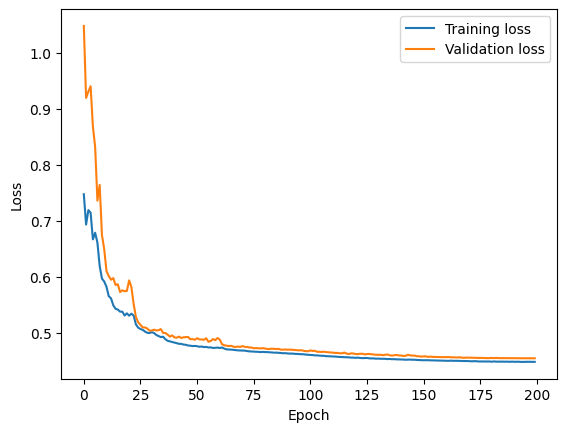

In [26]:
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
# Reconstruction des séquences
X_test_seq = create_sequences(X_test, timesteps=TIMESTEPS)
X_test_reconstructed = autoencoder.predict(X_test_seq)

reconstruction_error = np.mean(np.square(X_test_seq - X_test_reconstructed))

print("Reconstruction error (MSE) sur le test :", reconstruction_error)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Reconstruction error (MSE) sur le test : 0.4823464996076525


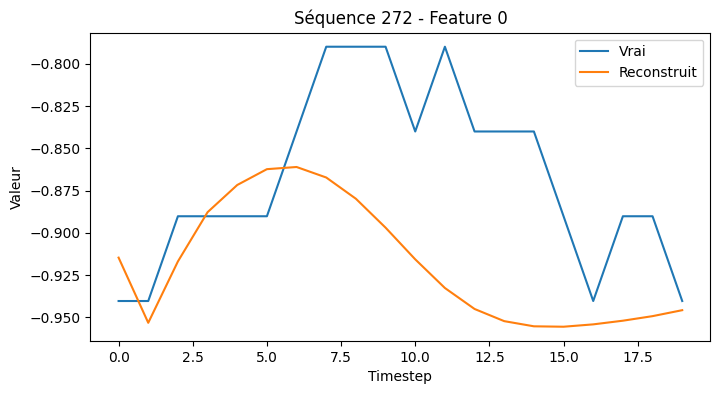

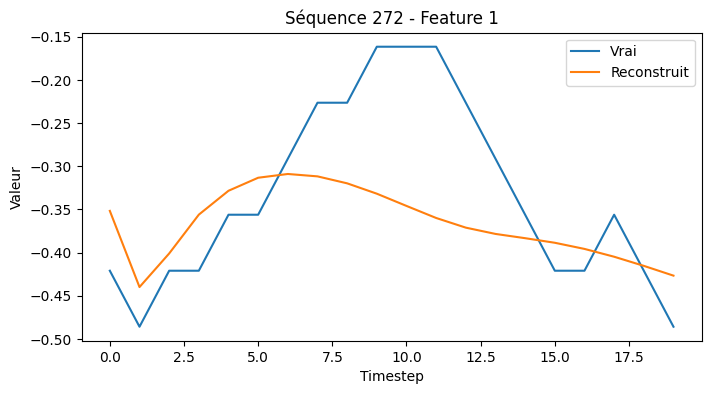

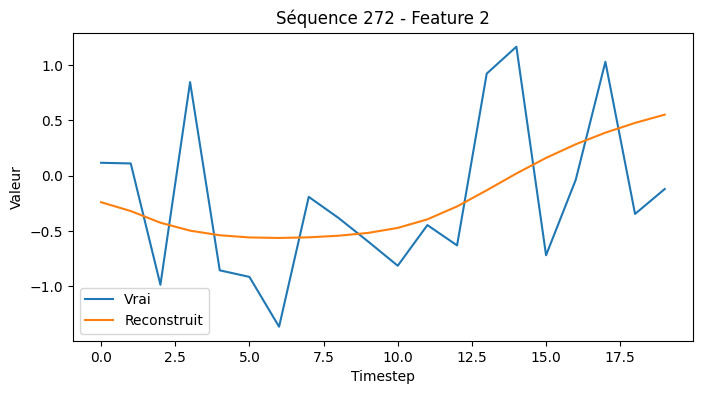

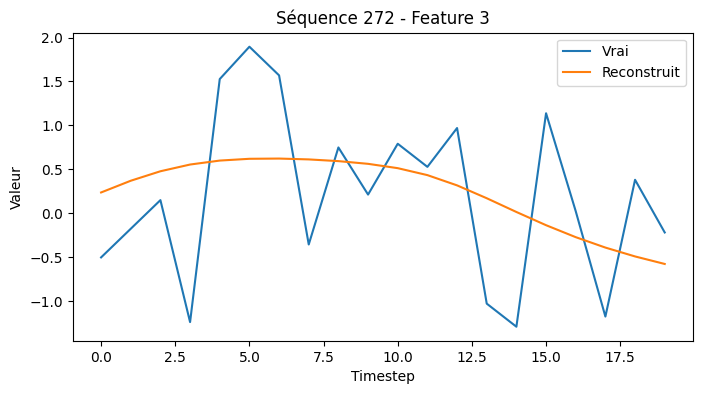

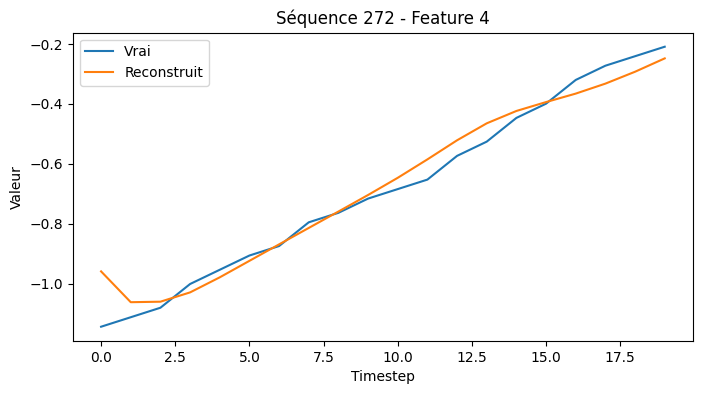

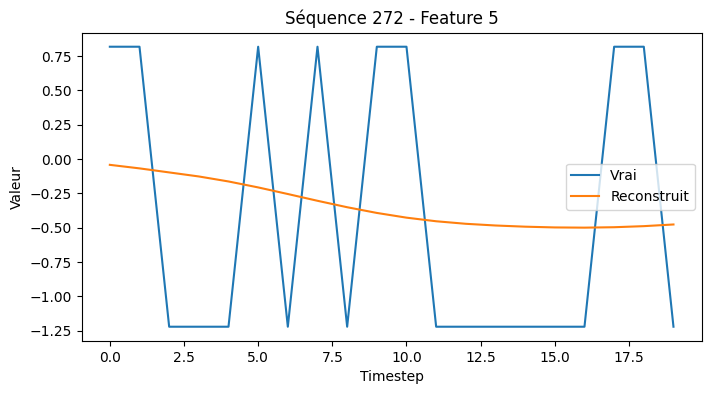

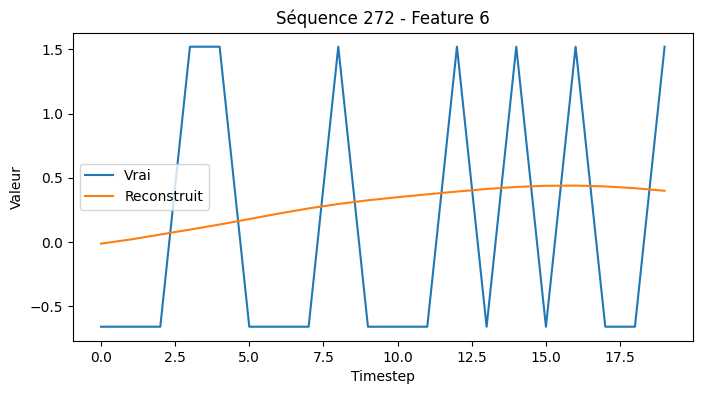

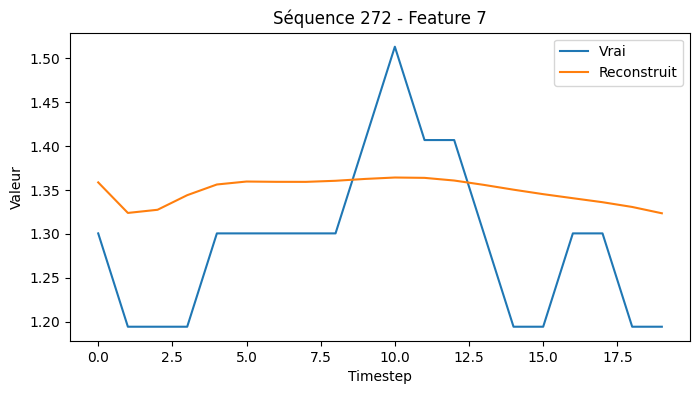

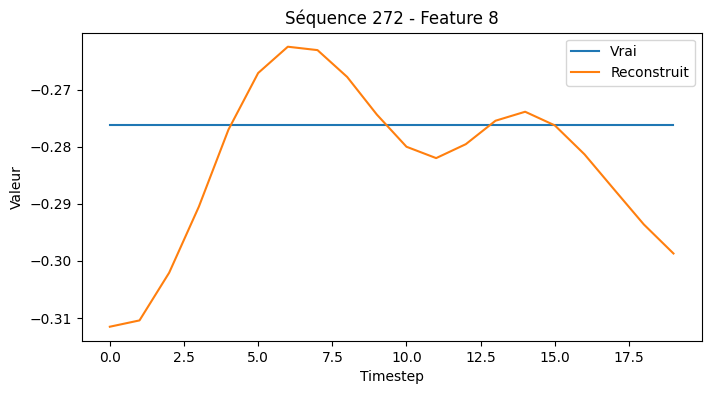

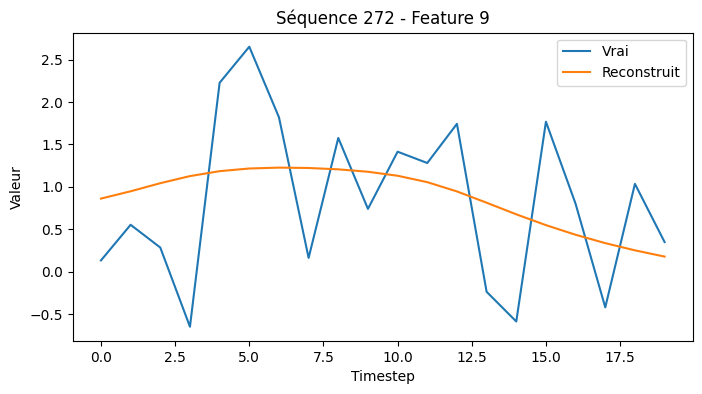

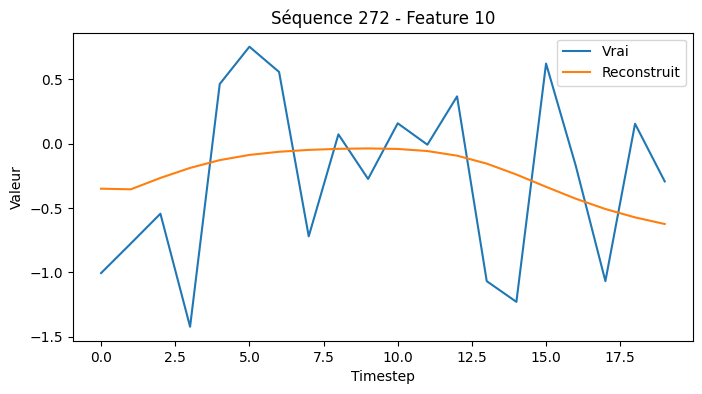

In [28]:
from random import randint


seq_idx = randint(0, X_test_seq.shape[0]-1)  # première séquence

for f in range(X_test_seq.shape[2]):  # pour chaque feature
    plt.figure(figsize=(8, 4))
    plt.plot(X_test_seq[seq_idx, :, f], label="Vrai")
    plt.plot(X_test_reconstructed[seq_idx, :, f], label="Reconstruit")
    plt.title(f"Séquence {seq_idx} - Feature {f}")
    plt.xlabel("Timestep")
    plt.ylabel("Valeur")
    plt.legend()
    plt.show()

In [29]:
autoencoder.save("../artifacts/autoencoder.keras")
encoder.save("../artifacts/encoder.keras")

In [30]:
y_test_seq = []
for i in range(len(y_test) - TIMESTEPS + 1):
    sequence_labels = y_test[i : i + TIMESTEPS]
    y_test_seq.append(1 if np.any(sequence_labels == 1) else 0)
y_test_seq = np.array(y_test_seq)
print(y_test_seq)

# Maintenant filtrer directement sur les séquences
X_test_seq_normal = X_test_seq[y_test_seq == 0]
X_test_reconstructed_normal = autoencoder.predict(X_test_seq_normal)

normal_error = np.mean(
    np.square(X_test_seq_normal - X_test_reconstructed_normal), axis=(1, 2)
)
print("MSE normal :", np.mean(normal_error))

# Pour les anomalies
X_test_seq_anomaly = X_test_seq[y_test_seq == 1]
X_test_reconstructed_anomaly = autoencoder.predict(X_test_seq_anomaly)

anomaly_error = np.mean(
    np.square(X_test_seq_anomaly - X_test_reconstructed_anomaly), axis=(1, 2)
)
print("MSE anomaly :", np.mean(anomaly_error))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
11/11 ━━━━━━━━━━━━━━━━━━

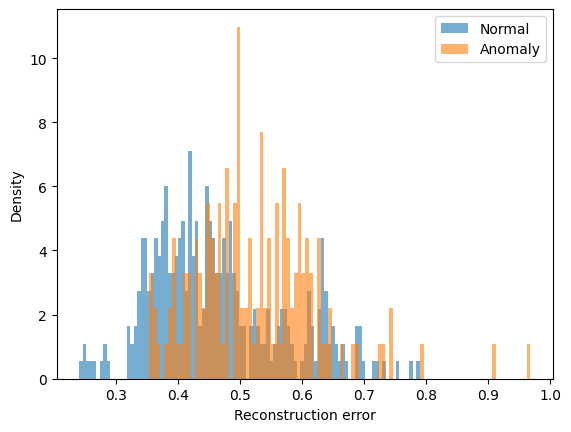

In [31]:
plt.figure()
plt.hist(normal_error, bins=100, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_error, bins=100, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.legend()
plt.show()